# TV shows Popularity Predictor (39%)

The goal of this challenge is to create a model that predicts the `popularity` of a movie or TV show

<img src="image.jpg" width=300 />




The dataset contains a list of movies and TV shows with the following characteristics:
- `title`: title of the movie in english
- `original_title`: original title of the movie 
- `duration_min`: duration of the movie in minutes
- `popularity`: popularity of the movie in terms of review scores
- `release_date`: release date
- `description`: short summary of the movie
- `budget`: budget spent to produce the movie in USD
- `revenue`: movie revenue in USD 
- `original_language`: original language 
- `status`: is the movie already released or not
- `number_of_awards_won`: number of awards won for the movie
- `number_of_nominations`: number of nominations
- `has_collection`: if the movie is part of a sequel or not
- `all_genres`: genres that described the movie (can be zero, one or many!) 
- `top_countries`: countries where the movie was produced (can be zero, one or many!) 
- `number_of_top_productions`: number of top production companies that produced the film if any. 
Top production companies includes: Warner Bros, Universal Pictures, Paramount Pictures, Canal+, etc...
- `available_in_english`: whether the movie is available in english or not

## Imports

Run the following cell to load the basic packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nbresult import ChallengeResult

/Users/Dandan/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Data collection

📝 **Load the `movie_popularity.csv` dataset from the provided this [URL](https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/tv_movies_popularity.csv)**
- First, check and remove the rows that may be complete duplicate from one another (we never know!)
- Then, drop the columns that have too much missing values
- Finally, drop the few remaining rows that have missing values
- Store the result in a `DataFrame` named `data`

In [2]:
data = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/tv_movies_popularity.csv')
data.shape

(6864, 17)

In [3]:
# calculate duplicates
duplicate_count=data.duplicated().sum()
duplicate_count

400

In [4]:
# remove duplicates
data = data.drop_duplicates().reset_index(drop=True)
data.shape

(6464, 17)

In [5]:
# identify the columns having too much missing values
round(data.isna().sum().sort_values(ascending = False)/len(data),3).head(3)

revenue           0.595
title             0.000
original_title    0.000
dtype: float64

In [6]:
# remove column 'revenue'
data=data.drop(columns='revenue')
data.shape

(6464, 16)

In [7]:
# identify the row(s) with missing values
data.isna().sum().sort_values

<bound method Series.sort_values of original_title               0
title                        1
popularity                   0
release_date                 0
duration_min                 0
description                  0
budget                       0
original_language            0
status                       0
number_of_awards_won         0
number_of_nominations        0
has_collection               0
all_genres                   0
top_countries                0
number_of_top_productions    0
available_in_english         0
dtype: int64>

In [8]:
data[data['title'].isna()]

,original_title,title,popularity,release_date,duration_min,description,budget,original_language,status,number_of_awards_won,number_of_nominations,has_collection,all_genres,top_countries,number_of_top_productions,available_in_english
5783,Barefoot,NaN,5.939334,2014-02-02,90.0,"The ""black sheep"" son of a wealthy family meet...",6000000,en,Released,0,1,0,"Comedy, Drama, Romance",other countries,0,False


In [9]:
# remove the row with missing value
data.drop(data.index[[5783]])
data.shape

(6464, 16)

### 🧪 Run the following cell to save your results

In [10]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "data_cleaning",
    columns=data.columns,
    cleaning=sum(data.isnull().sum()),
    shape=data.shape)
result.write()

## Baseline model

### The metric

📝 **We want to predict `popularity`: Start by plotting a histogram of the target to visualize it**

📝 **Which sklearn's scoring [metric](https://scikit-learn.org/stable/modules/model_evaluation.html) should we use if we want it to:**

- Be better when greater (i.e. metric_good_model > metric_bad_model)
- Penalize **more** an error between 10 and 20 compared with an error between 110 and 120
- Said otherwise, what matter should be the **relative error ratio**, more than the absolute error difference

Hint: the histogram plotted above should give you some intuition about it

👉 Store its exact [sklearn scoring name](https://scikit-learn.org/stable/modules/model_evaluation.html) as `string` in the variable `scoring` below.

🚨 You must use this metric for the rest of the challenge

/Users/Dandan/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


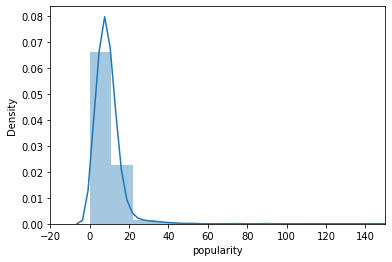

In [11]:
fig, ax = plt.subplots()
sns.distplot(data['popularity'], ax=ax)
ax.set_xlim(-20,150)
plt.show();

In [12]:
# my choice of metric
scoring = 'reg_mean_absolute_error'

<details>
    <summary>💡 Hint</summary>
It is around here!
<img src="scores.jpg" width=200 height=400 />
</details>

### X,y

**📝 Define `X` as the features Dataframe (keep all features) and `y` as the target Series.**

In [13]:
y = data['popularity']
X = data.drop(columns=['popularity'])

In [14]:
X.shape

(6464, 15)

In [46]:
# train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

### Basic pipeline

📝 **Check unique values per features**

In [15]:
features=list(X.columns)
features

['original_title',
 'title',
 'release_date',
 'duration_min',
 'description',
 'budget',
 'original_language',
 'status',
 'number_of_awards_won',
 'number_of_nominations',
 'has_collection',
 'all_genres',
 'top_countries',
 'number_of_top_productions',
 'available_in_english']

In [16]:
X.has_collection.value_counts()

0    5073
1    1391
Name: has_collection, dtype: int64

In [17]:
for feature in features:
    print(f"{[feature]} has {X[feature].nunique()} unique values")

['original_title'] has 6351 unique values
['title'] has 6337 unique values
['release_date'] has 4321 unique values
['duration_min'] has 152 unique values
['description'] has 6450 unique values
['budget'] has 636 unique values
['original_language'] has 42 unique values
['status'] has 3 unique values
['number_of_awards_won'] has 124 unique values
['number_of_nominations'] has 180 unique values
['has_collection'] has 2 unique values
['all_genres'] has 745 unique values
['top_countries'] has 320 unique values
['number_of_top_productions'] has 5 unique values
['available_in_english'] has 2 unique values


In [18]:
'''for feature in features:
    print(X[feature].value_counts())
'''

'for feature in features:\n    print(X[feature].value_counts())\n'

In this baseline, let's forget about the columns below that are difficult to process

In [19]:
text = ['description', 'original_title', 'title']
dates = ['release_date'] 

We will simply scale the numerical features and one-hot-encode the categorical ones remaining

📝 **Prepare 2 `list`s of features names as `str`**:
- `numerical` which contains **only** numerical features
- `categorical` which contains **only** categorical features (exept text and dates above)

In [20]:
data.dtypes

original_title                object
title                         object
popularity                   float64
release_date                  object
duration_min                 float64
description                   object
budget                         int64
original_language             object
status                        object
number_of_awards_won           int64
number_of_nominations          int64
has_collection                 int64
all_genres                    object
top_countries                 object
number_of_top_productions      int64
available_in_english            bool
dtype: object

In [21]:
numerical= X.select_dtypes(exclude=['object']).drop(columns='available_in_english').columns
numerical

Index(['duration_min', 'budget', 'number_of_awards_won',
       'number_of_nominations', 'has_collection', 'number_of_top_productions'],
      dtype='object')

In [22]:
X.select_dtypes(exclude=['object']).head()

,duration_min,budget,number_of_awards_won,number_of_nominations,has_collection,number_of_top_productions,available_in_english
0,93.0,14000000,0,2,1,3,True
1,113.0,40000000,1,2,1,1,True
2,105.0,3300000,97,145,0,0,True
3,122.0,1200000,23,18,0,0,True
4,92.0,14000000,0,6,0,0,True


In [23]:
categorical=X.drop(columns=numerical).drop(columns=text).drop(columns=dates).drop(columns='available_in_english').columns
categorical

Index(['original_language', 'status', 'all_genres', 'top_countries'], dtype='object')

### Pipelining

You are going to build a basic pipeline made of a basic preprocessing and a trees-based model of your choice.

#### Preprocessing pipeline

**📝 Create a basic preprocessing pipeline for the 2 types of features above:**
- It should scale the `numerical` features
- one-hot-encode the `categorical` and `boolean` features
- drop the others
- Store your pipeline in a `basic_preprocessing` variable

/Users/Dandan/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-25-621c277c94cf>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/Dandan/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-25-621c277c94cf>:15: UserWarning: Matplotlib is currently using module://ipykernel.

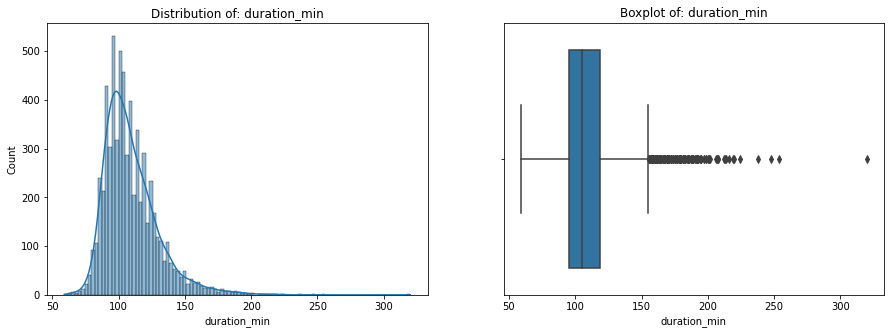

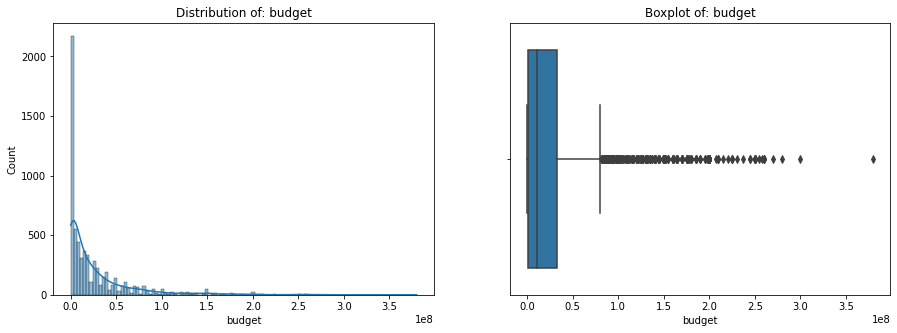

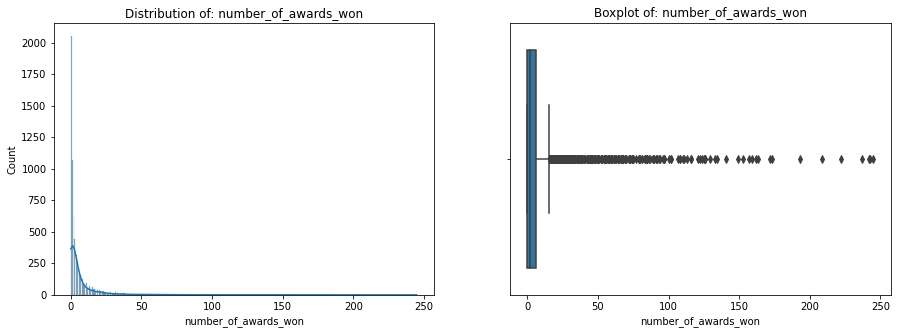

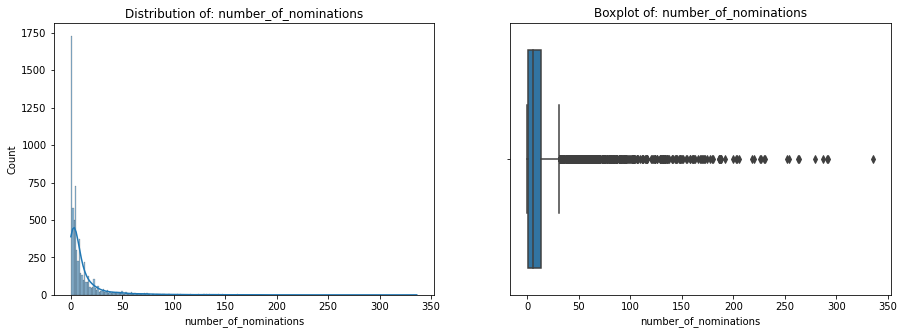

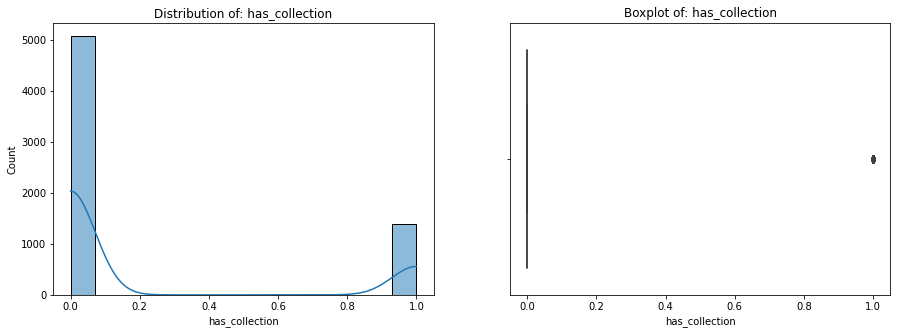

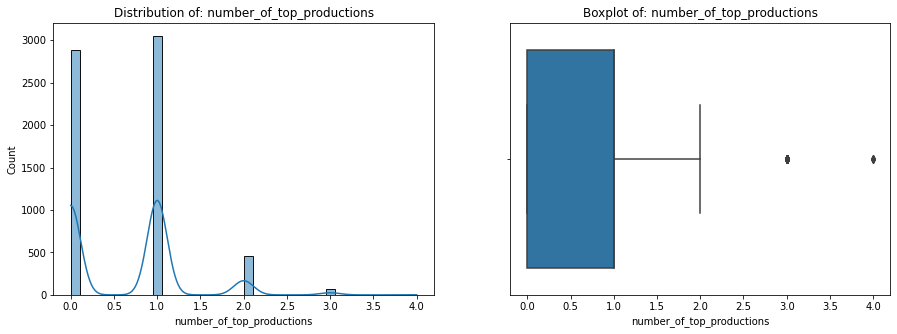

In [25]:
# decide which scaler to use (many outliers)
Numerical= X.select_dtypes(exclude=['object']).drop(columns='available_in_english')
for numerical_feature in numerical:
    
    fig, ax =plt.subplots(1,2,figsize=(15,5))
    
    ax[0].set_title(f"Distribution of: {numerical_feature}")
    sns.histplot(data = Numerical[numerical_feature], kde=True, ax=ax[0])
    
    ax[1].set_title(f"Boxplot of: {numerical_feature}")
    sns.boxplot(Numerical[numerical_feature], ax=ax[1])
    
    # ax[2].set_title(f"Gaussianity of: {numerical_feature}")
    # qqplot(Numerical[numerical_feature],line='s',ax=ax[2])
    
    fig.show()

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

In [42]:
pipe_num = Pipeline([
    ('scaler', RobustScaler())
    ])
    
pipe_cat = Pipeline([
    ('ohe',OneHotEncoder(handle_unknown='ignore'))
    ])

# Paralellize "num_transformer" and "cat_transformer"
preprocessor = ColumnTransformer([
    ('num_transformer', pipe_num,numerical), 
    ('cat_transformer', pipe_cat,['original_language', 'status', 'all_genres', 'top_countries','available_in_english'])   
    ])  
#preprocessor.fit_transform(X)

In [29]:
!pip install --upgrade scikit-learn

You should consider upgrading via the '/Users/Dandan/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8 -m pip install --upgrade pip' command.


In [43]:
# Execute this cell to enable a nice display for your pipelines
from sklearn import set_config; set_config(display='diagram')
preprocessor

ColumnTransformer(transformers=[('num_transformer',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 Index(['duration_min', 'budget', 'number_of_awards_won',
       'number_of_nominations', 'has_collection', 'number_of_top_productions'],
      dtype='object')),
                                ('cat_transformer',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['original_language', 'status', 'all_genres',
                                  'top_countries', 'available_in_english'])])

**📝 Encode the features and store the result in the variable `X_basic_preprocessing`.**

In [44]:
X_basic_preprocessing = pd.DataFrame(preprocessor.fit_transform(X)).head(3)
X_basic_preprocessing

,0
0,"(0, 0)\t-0.5\n (0, 1)\t0.09386344277028565\..."
1,"(0, 0)\t0.3333333333333333\n (0, 1)\t0.9073..."
2,"(0, 1)\t-0.2409161697770665\n (0, 2)\t15.83..."


**❓ How many features has been generated by the preprocessing? What do you think about this number?**

In [47]:
pipe_num = Pipeline([
    ('scaler', RobustScaler())
    ])
preprocessor1 = ColumnTransformer([
    ('num_transformer', pipe_num,numerical)
    ]) 
pd.DataFrame(preprocessor1.fit_transform(X)).head(3)

,0,1,2,3,4,5
0,-0.500000,0.093863,-0.333333,-0.250000,1.0,2.0
1,0.333333,0.907347,-0.166667,-0.250000,1.0,0.0
2,0.000000,-0.240916,15.833333,11.666667,0.0,-1.0


In [56]:
pipe_cat = Pipeline([
    ('ohe',OneHotEncoder(handle_unknown='ignore'))
    ])
preprocessor2 = ColumnTransformer([
    ('cat_transformer', pipe_cat,['available_in_english',,'status','all_genres','top_countries',])   
    ])  
pd.DataFrame(preprocessor2.fit_transform(X)).head(3)

,0
0,"(0, 1)\t1.0\n (0, 12)\t1.0"
1,"(0, 1)\t1.0\n (0, 12)\t1.0"
2,"(0, 1)\t1.0\n (0, 12)\t1.0"


In [ ]:
#remainder=drop by default otherwise 'passthrough' so remainder is dropped

# My answer: since there is a problem with the cat features, I can't see the number of it

#### Modeling pipeline

Let's add a model to our pipe. With so many features one-hot-encoded, we **need a model which can act as a feature selector**

👉 A linear model regularized with L1 penalty is a good starting point.


**📝 Create a `basic_pipeline` which encapsulate the `basic_preprocessing` pipeline + a linear model with a L1 penalty**

- store the resulting pipeline as `basic_pipeline`
- don't fine-tune it


<details>
    <summary>Hints</summary>

Choose your model from the list [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)

</details>

In [45]:
from sklearn.linear_model import Ridge

pipe_num = Pipeline([
    ('scaler', RobustScaler())
    ])    
pipe_cat = Pipeline([
    ('ohe',OneHotEncoder(handle_unknown='ignore'))
    ])
# preprocessor
basic_preprocessing = ColumnTransformer([
    ('num_transformer', pipe_num,numerical), 
    ('cat_transformer', pipe_cat,['original_language', 'status', 'all_genres', 'top_countries','available_in_english'])   
    ]) 
# Combine preprocessing and linear model in pipeline
basic_pipeline = Pipeline([
    ('preprocessing', basic_preprocessing),
    ('linear_regression', Ridge())]) 

basic_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  Index(['duration_min', 'budget', 'number_of_awards_won',
       'number_of_nominations', 'has_collection', 'number_of_top_productions'],
      dtype='object')),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['original_language',
                                                   'status', 'all_genres',
                                                   'top_countries',
                                                   'available_in_english'])])),
                ('linear_regression', Ridge())])

### Cross-validated baseline

**📝 Perform a cross-validated evaluation of your baseline model using the metric you defined above. Store the results of this evaluation as an `array` of floating scores in the `basic_scores` variable.**

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
cv_results = cross_validate(LinearRegression(), X, y, cv=5, 
                            scoring=['neg_mean_absolute_error'])
cv_results['test_neg_mean_absolute_error'] # it didn't work cause the value is nan

/Users/Dandan/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Dandan/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Dandan/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_base.py", line 518, in fit
    X, y = self._validate_data(X, y, accept_sparse=accept_sparse,
  File "/Users/Dandan/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/Dandan/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
 

array([nan, nan, nan, nan, nan])

### 🧪 Save your results

Run the following cell to save your results

In [64]:
ChallengeResult(
    'baseline',
    metric=scoring,
    features=[categorical,numerical],
    preproc=basic_preprocessing,
    preproc_shape=X_basic_preprocessing.shape,
    pipe=basic_pipeline,
    scores=basic_scores
).write()

NameError: name 'basic_scores' is not defined

## Feature engineering

### Time Features


👉 Let's try to improve performance using the feature `release_date`, and especially its `month` and `year`.

ℹ️ If you want to skip this section, you can move directly to the next one: _Advanced categorical features_.

**📝 Complete the custom transformer `TimeFeaturesExtractor` below**

Running
```python
TimeFeaturesExtractor().fit_transform(X[['release_date']])
``` 
should return something like

|    |   month |   year |
|---:|--------:|-------:|
|  0 |       2 |   2015 |
|  1 |       8 |   2004 |
|  2 |      10 |   2014 |
|  3 |       3 |   2012 |
|  4 |       8 |   2012 |


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class TimeFeaturesExtractor(BaseEstimator, TransformerMixin):
    """Extract the 2 time features from a date"""
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """
        Params:
        X: DataFrame
        y: Series
        
        Returns a DataFrame with 2 columns containing the time features as integers extracted from the release_date.
        """
        pass  # YOUR CODE HERE

In [ ]:
# Try your transformer and save your new features here
X_time_features = TimeFeaturesExtractor().fit_transform(X[['release_date']])
X_time_features.head()

We still have 2 problems to solve
- `month` is cyclical: 12 should be a close to 1 as to 11, right? 
- `year` is not scaled

**📝 Build a final custom transformer `CyclicalEncoder` so that**

Running
```python
CyclicalEncoder().fit_transform(X_time_features)
``` 
should return something like this

|    |    month_cos |   month_sin |      year |
|---:|-------------:|------------:|----------:|
|  0 |  0.5         |    0.866025 | 0.0466039 |
|  1 | -0.5         |   -0.866025 | 0.0411502 |
|  2 |  0.5         |   -0.866025 | 0.0461081 |
|  3 |  6.12323e-17 |    1        | 0.0451165 |
|  4 | -0.5         |   -0.866025 | 0.0451165 |

With the cyclical encoding is done as below
- `month_cos = 2 * math.pi / 12 * X[['month']] `
- `month_sin = 2 * math.pi / 12 * X[['month']] `

And the `year` begin min-max scaled

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import math

class CyclicalEncoder(BaseEstimator, TransformerMixin):
    """
    Encode a cyclical feature
    """
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        Compute here what you need for the transform phase and store it as instance variable
        """
        pass  # YOUR CODE HERE

    def transform(self, X, y=None):
        """
        Compute and returns the final DataFrame
        """
        pass  # YOUR CODE HERE

In [ ]:
# Try your transformer and save your new features here
X_time_cyclical = CyclicalEncoder().fit_transform(X_time_features)
X_time_cyclical.head()

In [ ]:
# Check that this form a circle with 12 points
plt.scatter(X_time_cyclical['month_cos'],
            X_time_cyclical['month_sin'])
plt.xlabel("month_cos"); plt.ylabel("month_sin");

**📝 Enhance your `basic_pipeline` with a new preprocessing including both `TimeFeaturesExtractor` and `CyclicalFeatureExtractor`:**

- Just use `TimeFeatureExtractor` if you haven't had time to do the `Cyclical` one
- Store this new pipeline as `time_pipeline`
- Keep same estimator for now

In [ ]:
# YOUR CODE HERE

### Advanced categorical encoder to reduce the number of features

ℹ️ Most of it has already been coded for you and it shouldn't take long. Still if you want to skip it and move to the next section: _Model Tuning_

👉 We need to reduce the number of features to one-hot-encode, which arise from the high cardinality of `all_genres` and `top_countries`

In [ ]:
X[['all_genres', 'top_countries']].nunique()

👇 Both share a common pattern: there can be more than 1 country and more than 1 genre per movie.

In [ ]:
X[['all_genres', 'top_countries']].tail()

👉 Run the cell below where we have coded for you a custom transformer `CustomGenreAndCountryEncoder` which: 
- Select the 10 most frequent genres and the 5 most frequent countries
- Encode `all_genres` into 10 One Hot Encoded features
- Encode `top_countries` into 5 One Hot Encoded features

In [ ]:
from collections import Counter
from sklearn.base import BaseEstimator, TransformerMixin

class CustomGenreAndCountryEncoder(BaseEstimator, TransformerMixin):
    """
    Encoding the all_genres and top_companies features which are multi-categorical :
    a movie has several possible genres and countries of productions!
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        compute top genres and top countries of productions from all_genres and top_countries features
        """

        # compute top 10 genres       
        list_of_genres = list(X['all_genres'].apply(lambda x: [i.strip() for i in x.split(",")] if x != [''] else []).values)
        top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(10)]

        # save top_genres in dedicated instance variable
        self.top_genres = top_genres
        
         # compute top 5 countries       
        list_of_countries = list(X['top_countries'].apply(lambda x: [i.strip() for i in x.split(",")] if x != [''] else []).values)
        top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(5)]

        # save top_countries in dedicated instance variable
        self.top_countries = top_countries

        return self

    def transform(self, X, y=None):
        """
        encoding genre and country
        """
        X_new = X.copy()
        for genre in self.top_genres:
            X_new['genre_' + genre] = X_new['all_genres'].apply(lambda x: 1 if genre in x else 0)
        X_new = X_new.drop(columns=["all_genres"])
        for country in self.top_countries:
            X_new['country_' + country] = X_new['top_countries'].apply(lambda x: 1 if country in x else 0)
        X_new = X_new.drop(columns=["top_countries"])
        return X_new

In [ ]:
# Check it out
X_custom = CustomGenreAndCountryEncoder().fit_transform(X[['all_genres', 'top_countries']])
print(X_custom.shape)
X_custom.head()

**📝 Compute your `final_pipeline` by integrating all these transformers** (or all those you have coded)

- `CustomGenreAndCountryEncoder`
- `TimeFeaturesExtractor`
- `CyclicalFeatureExtractor`

In [ ]:
# YOUR CODE HERE

📝 **Compute and store its cross validated scores as `final_scores` array of floats**

- It does not necessarily improve the performance before we can try-out doing model tuning
- However, with a now limited number of features, we will be able to train more complex models in next section (ensemble...)

### 🧪 Save your result

Run the following cell to save your results.

In [ ]:
ChallengeResult(
    'feature_engineering',
    X_time_features=X_time_features,
    X_time_cyclical= X_time_cyclical,
    time_pipeline=time_pipeline,
    final_pipeline=final_pipeline,
    final_scores=final_scores
).write()

# Hint: Try restarting your notebook if you obtain an error about saving a custom encoder

## Model tuning

### Random Forest

📝 **Change the estimator of your `final_pipeline` by a Random Forest and checkout your new cross-validated score**

In [ ]:
# YOUR CODE HERE

### Best hyperparameters quest



**📝 Fine tune your model to try to get the best performance in the minimum amount of time!**

- Store the result of your search inside the `search` variable.
- Store your 5 cross-validated scores inside `best_scores` array of floats

In [ ]:
# YOUR CODE HERE

**📝 Re-train your best pipeline on the whole (X,y) dataset**
- Store the trained pipeline inside the `best_pipeline` variable

In [ ]:
# YOUR CODE HERE

### Prediction

Now you have your model tuned with the best hyperparameters, you are ready for a prediction.

Here is a famous TV show released in 2017:

```python
dict(
        original_title=str("La Casa de Papel"),
        title=str("Money Heist"), 
        release_date= pd.to_datetime(["2017-05-02"]), 
        duration_min=float(50),
        description=str("An unusual group of robbers attempt to carry out the most perfect robbery"), 
        budget=float(3_000_000), 
        original_language =str("es"), 
        status=str("Released"),
        number_of_awards_won =int(2), 
        number_of_nominations=int(5), 
        has_collection=int(1),
        all_genres=str("Action, Crime, Mystery"), 
        top_countries=str("Spain, France, United States of America"), 
        number_of_top_productions=int('1'),
        available_in_english=bool('True') 
)
```

**📝 Compute the predicted popularity of this TV show and store it into the `popularity` variable as a floating number.**

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

### 🧪 Save your results

Run the following cell to save your results.

In [ ]:
ChallengeResult(
    "model_tuning",
    search=search,
    best_pipeline=best_pipeline,
    best_scores = best_scores,
    popularity=popularity
).write()

## API 

Time to put a pipeline in production!

👉 Go to https://github.com/lewagon/data-certification-api and follow instructions

**This final part is independent from the above notebook**